# Binaryclassifier for prediction of Match-winner using Logistic Regression.

## Model Selection


The model is selected based on the factors considering the complexity and also the computation time. 
    Logistic Regression preforms good on dataset containing fewer amount of samples and less number of feature sets compared to that of the other classfier.  

import the libraries required to design the classifier.

In [11]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score,classification_report,roc_curve, auc
from sklearn import linear_model,metrics

Dataset Preprocessing
=======================================

The dataset consists of the 28 featurs as the input and the output as binary values assigned predicting the winner of the match based on these feature set. The values are assigned as team 1=1 and team 2=0 for the winning team. The dataset preprocessing for this problem statement is as follows:
        1. Load the Data
        2. Extract the features  (Neglect less contributing factors)
        3. Feature slection using PCA
        4. Class_weight vector calculation based on the occurance of each example in the dataset.

1.Loading the Dataset

In [2]:
Train_data = pd.read_csv('/home/manoj/Downloads/train.csv - train.csv.csv')
Test_data = pd.read_csv('/home/manoj/Downloads/test.csv')

2.Extract the features  (Neglect less contributing factors)
The datamine function takes input as the data_path and reutrns the features set and the labels.The following conditions and modifications are applied to the dataset.
    1. Team1 is set to the value 1 and Team2 is set to the value 0
As the model learns accordingly to the feature set and all the examples are assigned accordingly, it is valid to assign the values.
    2. City values are assigned accordingly to that of the team factor.
assuming that the home match favours the home team the values are assigned accordingly t that of home ground and some venues are away match for both the playing team in that case the value is assigned to -1.
    3. Time and date factors are neglected assuming that there is not much variance in the feature. 
   
    

In [3]:
def datamine(data_path):
    df = pd.DataFrame(data_path)
    labels = df['Winner (team 1=1, team 2=0)']
    Team1 = df.ix[:,1]
    Team2 = df.ix[:, 2]
    city = df.ix[:, 3]
    value = np.zeros((len(Team1),1))
    for i in range(0,len(Team1)):
        if city[i] in Team1[i]:
            value[i] = 1
        elif city[i] in Team2[i]:
            value[i] = 0
        else:
            value[i] = -1

    value1 = np.ones((len(Team1),1))
    value2 = np.zeros((len(Team1),1))
    value3 = df.ix[:,4:29]
    value3 = np.concatenate((value1,value2,value,value3),axis=1)
    value3 = np.delete(value3,[4,5],1)
    return value3,labels

3.Dimension Reduction Using Principle Component Analysis
Considering all the features set initially, doing PCA and then finding the variance plot for the set. Further on observing the variance plot we can see that 99.4 of the data varince can be observed in 23-24 features axis. So further reducing the dataset to 23 axis.

In [4]:
def PCA_ext_feature(data_input,nn_components,Transform = False):
    if Transform:
        pca = PCA(n_components=nn_components)
        pca.fit(data_input)
        X1 = pca.fit_transform(data_input)
        return X1

    else :
        pca = PCA(n_components=nn_components)
        pca.fit(data_input)
        var = pca.explained_variance_ratio_
        var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4) * 100)
        print var1
        plt.plot(var1)


Assigning the values using the above functions.

[  19.54   28.6    36.3    42.76   48.3    53.74   58.73   63.56   67.76
   71.93   75.58   78.47   81.36   84.15   86.81   89.05   90.96   92.81
   94.54   96.05   97.43   98.46   99.4   100.03  100.03  100.03]
252


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


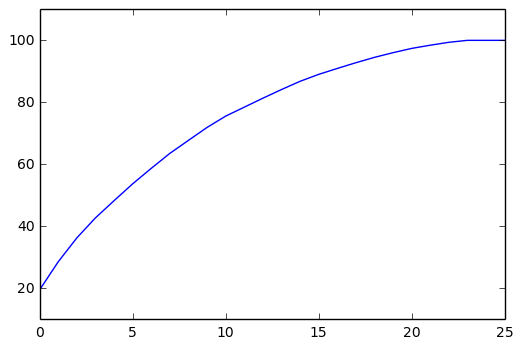

In [5]:
[X_train,labels_train] = datamine(data_path=Train_data)
X_train = scale(X_train)
PCA_ext_feature(data_input=X_train,nn_components=26)
X_train1 = PCA_ext_feature(data_input=X_train,nn_components=23,Transform=True)
print len(labels_train)

In [6]:
X_train = X_train1[0:200,:]
X_val = X_train1[201:252,:]
Y_train = labels_train[0:200]
Y_val = labels_train[201:252]

4.Calculating the Class_Weight factor for weight calibration.
   
   
   The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as 
       
       n_samples / (n_classes * np.bincount(y)).

Classifier Modelling
=======================================

The logisitic Regression classifier Model is used to train the dataset for classification, The parameters considered are C(Regularisation factor) where smaller the value, gives stronger regularisation. Number of iterations and class_weight factor for smooth modelling of dataset. 

In [7]:
logreg = linear_model.LogisticRegression(C=1e-4,max_iter=400,class_weight='balanced')
logreg.fit(X_train,Y_train)
Y_pred = logreg.predict(X_val)

Receiver Operating Characteristic (ROC)
=======================================

Receiver Operating Characteristic (ROC) metric to evaluate
classifier output quality.

ROC curves typically feature true positive rate on the Y axis, and false
positive rate on the X axis. This means that the top left corner of the plot is
the "ideal" point - a false positive rate of zero, and a true positive rate of
one. This is not very realistic, but it does mean that a larger area under the
curve (AUC) is usually better.

The "steepness" of ROC curves is also important, since it is ideal to maximize
the true positive rate while minimizing the false positive rate.


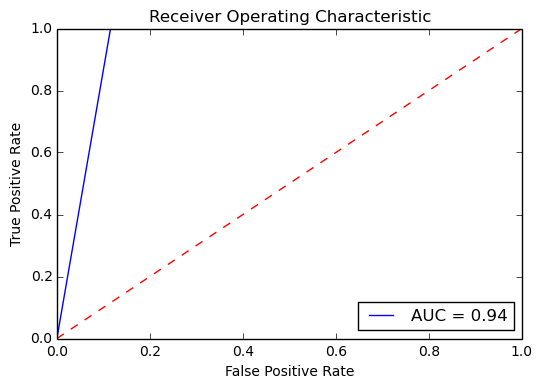

In [8]:
fpr, tpr, threshold = metrics.roc_curve(Y_val, Y_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Accuracy Analysis
=======================================

Calculating the accuracy score and also the sensitivity and selectivity of the trained model.

In [9]:
accuracy_score(Y_val, Y_pred)
target_names = ['class negative', 'class positive']
print "Confusion Matrix"
print(classification_report(Y_val, Y_pred, target_names=target_names))
score = accuracy_score(Y_val, Y_pred)
print(
        "Accuracy is: %.1f%%" %
        (score* 100)
    )

Confusion Matrix
                precision    recall  f1-score   support

class negative       1.00      0.88      0.94        26
class positive       0.89      1.00      0.94        25

   avg / total       0.95      0.94      0.94        51

Accuracy is: 94.1%


Model Implementation
=======================================

Predicting the ouput on the testset. 

In [10]:
[X_test,labels_test] = datamine(data_path=Test_data)
X_test = scale(X_test)
X_test = PCA_ext_feature(data_input=X_test,nn_components=23,Transform=True)
Y_test = logreg.predict(X_test)
print Y_test

[1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1
 0 0 0 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 1
 1 1]
